In [1]:
import sys
import os
from time import time

import cv2
import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from skimage import measure

sys.path.insert(0, os.path.abspath('..'))

from src.utils.load_cfg import ConfigLoader
from src.factories import ModelFactory
from src.factories import DatasetFactory
from src.utils.misc import MiscUtils
from src.models.pytorch_ssim.ssim import SSIM

import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

import seaborn as sns
sns.set_style('whitegrid', {'axes.grid': False})

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dataset_cfg = '../configs/dataset_cfgs/epickitchens_short.yaml'
train_cfg = '../configs/train_cfgs/train_san_freeze_short.yaml'
model_cfg = '../configs/model_cfgs/pipeline2_rgbspec_san19pairfreeze_actreggru_halluconvlstm.yaml'
weight = '../saved_models/san19freeze_halluconvlstm_actreggru/dim32_layer1_nsegment10/epoch_00049.model'
model_cfg_mod = {'num_segments': 10, 'hallu_model_cfg': 'exp_cfgs/haluconvlstm_32_1.yaml'}

In [2]:
# Deprocess data for visualization
def deprocess_rgb(rgb, num_segments):
    rgb = rgb.cpu().numpy()
    assert rgb.shape[0] == 1
    _, _, h, w = rgb.shape
    rgb = rgb.reshape([num_segments, 3, h, w]).transpose(0, 2, 3, 1)
    rgb *= 1  # std
    rgb += np.array([104, 117, 128])  # mean
    rgb = rgb.astype(np.uint8)
    return rgb


def deprocess_flow(flow, num_segments, new_length):
    flow = flow.cpu().numpy()
    assert flow.shape[0] == 1
    _, _, h, w = flow.shape
    flow = flow.reshape([num_segments, new_length, 2, h, w])
    flow *= 1  # std
    flow += 128  # mean
    flow = flow.astype(np.uint8)
    flow_x = flow[:, :, 0, :, :]
    flow_y = flow[:, :, 1, :, :]
    return flow_x, flow_y


def deprocess_spec(spec, num_segments):
    spec = spec.cpu().numpy()
    assert spec.shape[0] == 1
    _, _, h, w = spec.shape
    spec = spec.reshape([num_segments, h, w])
    return spec


def display_input(sample, num_segments):
    # Deprocess inputs
    rgb = deprocess_rgb(sample['RGB'], num_segments)
    spec = deprocess_spec(sample['Spec'], num_segments)

    # Display input RGB
    fig, axes = plt.subplots(1, num_segments, figsize=(3*num_segments, 5))
    fig.suptitle('='*30+'\n  RGB\n'+'='*30, fontsize=15)
    fig.tight_layout()
    fig.subplots_adjust(top=0.95)
    for i in range(num_segments):
        axes[i].imshow(cv2.cvtColor(rgb[i], cv2.COLOR_BGR2RGB))
        axes[i].axis('off')

    # Display input Spec
    fig, axes = plt.subplots(1, num_segments, figsize=(3*num_segments, 5))
    fig.suptitle('='*30+'\n  Spec\n'+'='*30, fontsize=15)
    fig.tight_layout()
    fig.subplots_adjust(top=0.95)
    for i in range(num_segments):
        axes[i].imshow(spec[i], cmap='viridis')
        axes[i].axis('off')

In [3]:
# Load configurations
model_name, model_params = ConfigLoader.load_model_cfg(model_cfg)
dataset_name, dataset_params = ConfigLoader.load_dataset_cfg(dataset_cfg)
train_params = ConfigLoader.load_train_cfg(train_cfg)

if model_cfg_mod is not None:
    model_params.update(model_cfg_mod)

dataset_params.update({
    'modality': model_params['modality'],
    'num_segments': model_params['num_segments'],
    'new_length': model_params['new_length'],
})

# Build model
model_factory = ModelFactory()
model = model_factory.generate(model_name, device=device, model_factory=model_factory, **model_params)
model.load_model(weight)
model = model.to(device)
model.eval()

# Get training augmentation and transforms
train_augmentation = MiscUtils.get_train_augmentation(model.modality, model.crop_size)
train_transform, val_transform = MiscUtils.get_train_val_transforms(
    modality=model.modality,
    input_mean=model.input_mean,
    input_std=model.input_std,
    scale_size=model.scale_size,
    crop_size=model.crop_size,
    train_augmentation=train_augmentation,
)

# Data loader
dataset_factory = DatasetFactory()
loader_params = {
    'batch_size': train_params['batch_size'],
    'num_workers': train_params['num_workers'],
    'pin_memory': True,
}

val_dataset = dataset_factory.generate(dataset_name, mode='val', transform=val_transform, **dataset_params)
val_loader = DataLoader(val_dataset, shuffle=False, **loader_params)

In [4]:
sample_id = 64

# Get a sample
for i, (sample, target) in enumerate(val_loader):
    sample = {k: v.to(device) for k, v in sample.items()}
    target = {k: v.to(device) for k, v in target.items()}

    if i == sample_id:
        break

# Forward
with torch.no_grad():
    output = model(sample)
    attn = model._attn[0]
    attn_pool = torch.nn.functional.avg_pool2d(attn, 2)
    
rgb = deprocess_rgb(sample['RGB'], model.num_segments)

Masking: 8.487701416015625e-05
Label segments: 0.00015783309936523438
Find bounding boxes: 0.00016021728515625
[19.14170074 17.16983223 12.48536873]
[2 6 8]


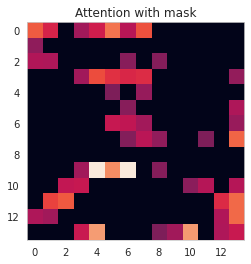

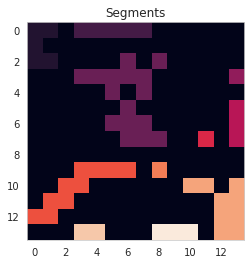

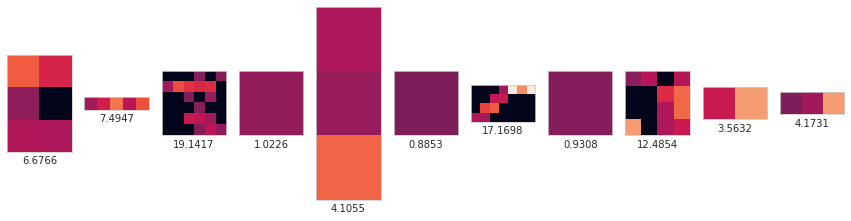

In [5]:
attn_ = attn[0].mean(dim=0).cpu().detach().numpy()
top_k = 3

# Mask the attention by thresholding
thres = 1.0*attn_.mean() + 0.1*attn_.std()
# print(attn_.min(), attn_.max(), attn_.mean(), thres)
st = time()
mask = np.where(attn_>thres, 1.0, 0.0)
print('Masking:', time()-st)

# Show the attention map with masking
plt.figure()
plt.imshow(mask*attn_)
plt.title('Attention with mask')

# Segment the mask
st = time()
segments, n_seg = measure.label(mask, return_num=True)
print('Label segments:', time()-st)
plt.figure()
plt.imshow(segments)
plt.title('Segments')

# Find bounding boxes
st = time()
props = measure.regionprops(segments)
print('Find bounding boxes:', time()-st)

# Find the top segments
scores = np.zeros(n_seg)
vmin, vmax = 0, attn_.max()
fig, axes = plt.subplots(1, len(props), figsize=(15, 5))
for i, prop in enumerate(props):
    scores[i] = attn_[prop.coords[:, 0], prop.coords[:, 1]].sum()
    axes[i].imshow((mask*attn_)[prop.bbox[0]:prop.bbox[2], prop.bbox[1]:prop.bbox[3]],
                   vmin=vmin, vmax=vmax)
    axes[i].set_xlabel('{:.04f}'.format(scores[i]))
    axes[i].get_xaxis().set_ticks([])
    axes[i].get_yaxis().set_ticks([])
    
top_segids = scores.argsort()[::-1][:top_k]
print(scores[top_segids])
print(top_segids)

[2 6 8] 16.0
19.141700744628906 : (5, 6) 6 (2, 3, 8, 9)
--> (80, 96) 96 (32, 48, 128, 144)
--> (32, 48, 128, 144) 96 96
32 48 128 144 96 96
(96, 96, 3)

17.169832229614258 : (11, 3) 7 (9, 0, 13, 7)
--> (176, 48) 112 (120, -8, 232, 104)
--> (112, 0, 224, 112) 112 112
112 0 224 112 112 112
(112, 112, 3)

12.485368728637695 : (12, 12) 4 (10, 10, 14, 14)
--> (192, 192) 64 (160, 160, 224, 224)
--> (160, 160, 224, 224) 64 64
160 160 224 224 64 64
(64, 64, 3)



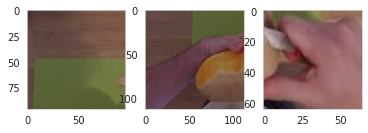

In [6]:
img_size = 224
attn_size = attn_.shape[-1]
scale = img_size / attn_size
min_b_size = 64
max_b_size = 112

print(top_segids, scale)
fig, axes = plt.subplots(1, top_k)
for i, sid in enumerate(top_segids):
    min_row, min_col, max_row, max_col = props[sid].bbox
    b_h, b_w = max_row-min_row, max_col-min_col
    b_size = max(b_h, b_w)
    b_center = ((max_row+min_row)//2, (max_col+min_col)//2)
    print(scores[sid], ':', b_center, b_size, props[sid].bbox)
    
    # Convert to image scale
    b_center_img = (int(b_center[0]*scale), int(b_center[1]*scale))
    b_size_img = np.clip(int(b_size * scale), min_b_size, max_b_size)
        
    top = b_center_img[0] - b_size_img//2
    bottom = b_center_img[0] + b_size_img//2
    left = b_center_img[1] - b_size_img//2
    right = b_center_img[1] + b_size_img//2
    
    print('-->', b_center_img, b_size_img, (top, left, bottom, right))
    
    # Adjust
    if top < 0:
        bottom -= top
        top -= top
    if left < 0:
        right -= left
        left -= left
    if bottom > img_size:
        top -= (bottom - img_size)
        bottom -= (bottom - img_size)
    if right > img_size:
        left -= (right - img_size)
        right -= (right - img_size)
    print('-->', (top, left, bottom, right), bottom-top, right-left)
    
    print(top, left, bottom, right, bottom-top, right-left)
    print(rgb[0][top:bottom, left:right, :].shape)
    axes[i].imshow(cv2.cvtColor(rgb[0][top:bottom, left:right, :], cv2.COLOR_BGR2RGB))
    print()

In [7]:
def project_image_plane(prop, img_size, min_b_size, max_b_size):
    """Project bounding boxes to image plane
    """
    # Get the bbox in attn plane
    min_row, min_col, max_row, max_col = prop.bbox
    b_h, b_w = max_row-min_row, max_col-min_col
    b_size = max(b_h, b_w)
    b_center = ((max_row+min_row)//2, (max_col+min_col)//2)
    
    # Convert to the scale of image plane
    b_center_img = (int(b_center[0]*scale), int(b_center[1]*scale))
    b_size_img = np.clip(int(b_size*scale), min_b_size, max_b_size)
    
    top = b_center_img[0] - b_size_img//2
    bottom = b_center_img[0] + b_size_img//2
    left = b_center_img[1] - b_size_img//2
    right = b_center_img[1] + b_size_img//2
    
    # Adjust the bbox to get a square one
    if top < 0:
        bottom -= top
        top -= top
    if left < 0:
        right -= left
        left -= left
    if bottom > img_size:
        top -= (bottom - img_size)
        bottom -= (bottom - img_size)
    if right > img_size:
        left -= (right - img_size)
        right -= (right - img_size)
        
    assert (bottom-top == b_size_img) and (right-left == b_size_img)
    
    return top, left, bottom, right


def get_bbox_from_attn(attn, top_k, alpha=1.0, beta=0.1):
    """Segment and get bbox from attention map
    """
    # Mask the attention by thresholding
    thres = alpha*attn.mean() + beta*attn.std()
    mask = np.where(attn>thres, 1.0, 0.0)

    # Segment the mask
    segments, n_seg = measure.label(mask, return_num=True)

    # Find bounding boxes
    props = measure.regionprops(segments)

    # Find the top segments
    scores = np.zeros(n_seg)
    for i, prop in enumerate(props):
        scores[i] = attn_[prop.coords[:, 0], prop.coords[:, 1]].sum()
    top_segids = scores.argsort()[::-1][:top_k]
    
    return props, top_segids, mask, segments, scores


def run_experiment(model, val_loader, sample_id, top_k, alpha, beta, min_b_size, max_b_size):
    """Run the experiment
    """
    # Get a sample
    for i, (sample, target) in enumerate(val_loader):
        sample = {k: v.to(device) for k, v in sample.items()}
        target = {k: v.to(device) for k, v in target.items()}

        if i == sample_id:
            break

    # Forward
    with torch.no_grad():
        output = model(sample)
        attn = model._attn[0]
        # attn_pool = torch.nn.functional.avg_pool2d(attn, 2)

    rgb = deprocess_rgb(sample['RGB'], model.num_segments)
    img_size = rgb.shape[1]
    
    # For each frame
    fig, axes = plt.subplots(4, model.num_segments, figsize=(20, 10))
    for t in range(model.num_segments):
        rgb_ = cv2.cvtColor(rgb[t], cv2.COLOR_BGR2RGB)
        attn_ = attn[t].mean(dim=0).cpu().detach().numpy()
        
        props, top_segids, mask, segments, scores = get_bbox_from_attn(attn_, top_k, alpha, beta)
        bboxes = []
        for sid in top_segids:
            top, left, bottom, right = project_image_plane(props[sid], img_size, min_b_size, max_b_size)
            bboxes.append((top, left, bottom, right))
        
        # Mark on image
        tmp = np.copy(rgb_)
        tmp[bboxes[0][0]:bboxes[0][2], bboxes[0][1]:bboxes[0][3], 0] = 255
        tmp[bboxes[1][0]:bboxes[1][2], bboxes[1][1]:bboxes[1][3], 1] = 255
        tmp[bboxes[2][0]:bboxes[2][2], bboxes[2][1]:bboxes[2][3], 2] = 255
            
        # Visualize
        axes[0, t].imshow(rgb_)
        axes[1, t].imshow(attn_)
        axes[2, t].imshow(segments)
        axes[3, t].imshow(tmp)
    
    for ax in axes.ravel():
        ax.get_xaxis().set_ticks([])
        ax.get_yaxis().set_ticks([])
    axes[0, 0].set_ylabel('RGB')
    axes[1, 0].set_ylabel('attention')
    axes[2, 0].set_ylabel('segments')
    axes[3, 0].set_ylabel('bbox')

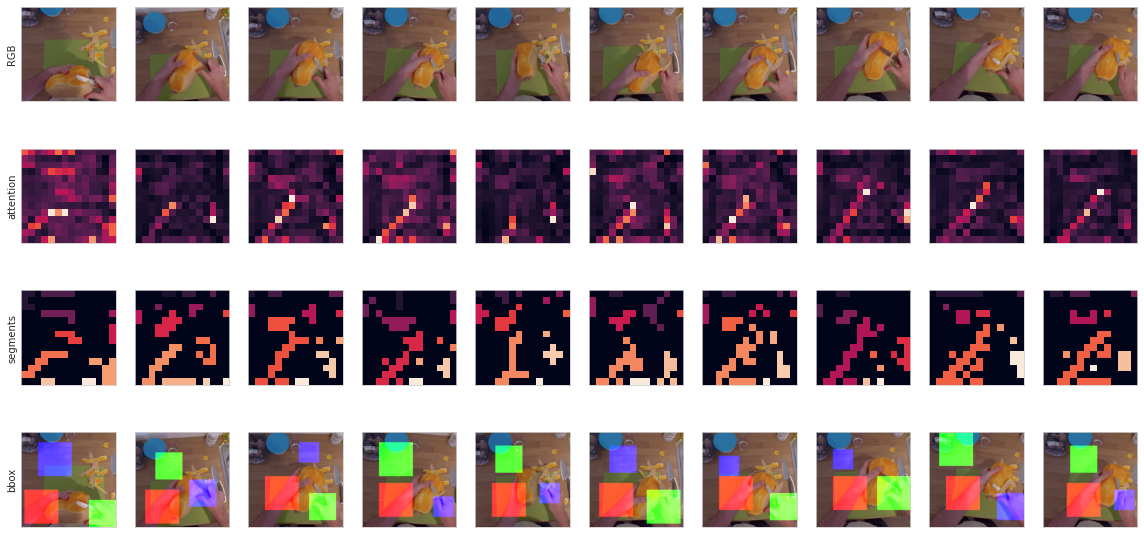

In [8]:
sample_id = 64
alpha, beta = 1.0, 0.3
min_b_size, max_b_size = 32, 80
run_experiment(model, val_loader, sample_id, top_k, alpha, beta, min_b_size, max_b_size)

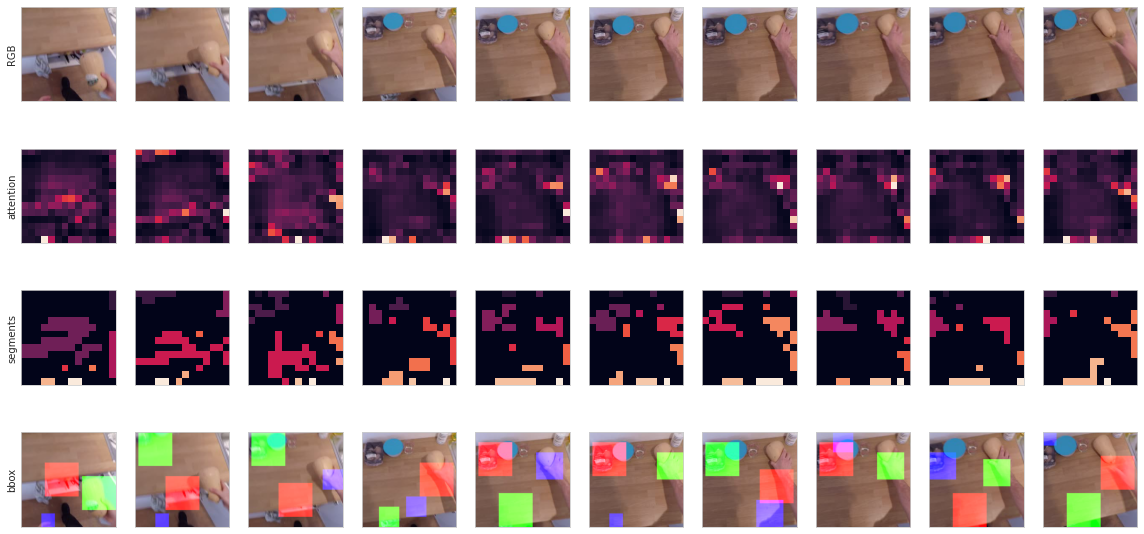

In [9]:
sample_id = 17
alpha, beta = 1.0, 0.3
min_b_size, max_b_size = 32, 80
run_experiment(model, val_loader, sample_id, top_k, alpha, beta, min_b_size, max_b_size)

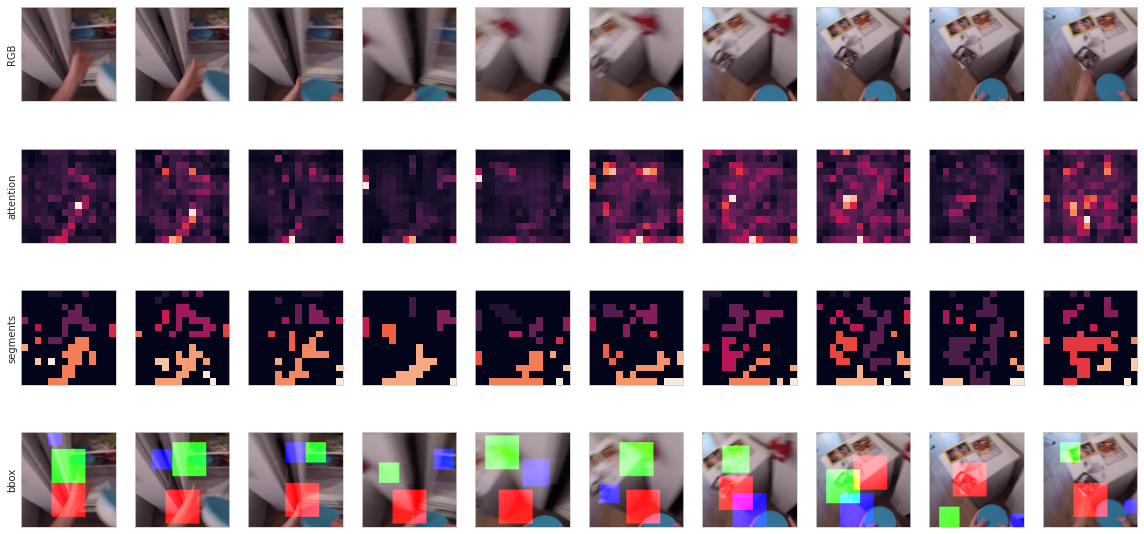

In [10]:
sample_id = 7
alpha, beta = 1.0, 0.3
min_b_size, max_b_size = 32, 80
run_experiment(model, val_loader, sample_id, top_k, alpha, beta, min_b_size, max_b_size)